In [17]:
import os
import sys
from random import randint
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import numpy as np

In [33]:
BS = 32
train_dataloader = DataLoader(MNIST(root="../datasets/", train=True, transform=ToTensor(), download=False),
                              batch_size=32,
                              shuffle=True)
test_dataloader = DataLoader(MNIST(root="../datasets/", train=False, transform=ToTensor(), download=False),
                             batch_size=32,
                             shuffle=False)

tensor(3)


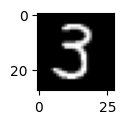

In [19]:
i = randint(0, 60_000)
sample = (train_dataloader.dataset.data[i])
label = (train_dataloader.dataset.targets[i])
plt.figure(figsize=(1,1))
plt.imshow(sample, cmap='gray')
print(label)

In [36]:
class Net1(nn.Module):
    def __init__(self, path, load_existing=True):
        super().__init__()
        self.path = path
        self.layer_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(in_features=14*14*4, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=10),
            nn.Softmax(dim=1)
        )
        if load_existing and os.path.exists(self.path):
            self.load_state_dict(torch.load(self.path))
            print("Loaded existing model:", self.path)
        else:
            torch.save(self.state_dict(), self.path) 
            print("Saved new model:", self.path)

    def forward(self, x):
        return self.layer_stack(x)

In [21]:
device = torch.device("mps")

In [22]:
net = Net1("nets/danet.pt", False)

Saved new model: nets/danet.pt


In [31]:
N_EPOCHS = 1
N_SAMPLES = 60_000
N_BATCHES = N_SAMPLES/BS

def train_model(model: nn.Module, n_epochs, LR, MOM):
    model.train()
    #model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(params=model.parameters(), lr=LR)
    losses = []
    accs = []
    print("bp")
    for n_epoch in range(N_EPOCHS):
        print(f"N_Epoch {n_epoch}/{N_EPOCHS}")
        for n_batch, (x, y) in enumerate(train_dataloader):
            x = x
            pred = model(x)
            optim.zero_grad()
            loss = criterion(pred, y)
            loss_a = loss.item()/BS
            losses.append(loss_a)
            acc = (pred.argmax(dim=1)==y).sum().item()/BS
            accs.append(acc)
            if n_batch % 50:
                print(f"     Batch: {n_batch}/{N_BATCHES} --- Loss: {loss_a}, Acc: {acc}")
            loss.backward()
            optim.step()
        torch.save(model.state_dict(), model.path)
        print("Saved model:", model.path) 

    return losses, accs

def eval_model(model: nn.Module):
    model.eval()
    acc = 0
    for x, y in test_dataloader:
        pred = model(x)
        acc += (pred.argmax(dim=1)==y).sum().item()
    print(f"Acc: {acc}/10000")

In [27]:
losses, accs = train_model(net, 1, 0.01, 0.0)

bp
N_Epoch 0/1
     Batch: 1/1875.0 --- Loss: 0.045830290764570236, Acc: 1.0
     Batch: 2/1875.0 --- Loss: 0.048533812165260315, Acc: 0.90625
     Batch: 3/1875.0 --- Loss: 0.050654955208301544, Acc: 0.84375
     Batch: 4/1875.0 --- Loss: 0.047920260578393936, Acc: 0.9375
     Batch: 5/1875.0 --- Loss: 0.0483112558722496, Acc: 0.90625
     Batch: 6/1875.0 --- Loss: 0.04732358828186989, Acc: 0.9375
     Batch: 7/1875.0 --- Loss: 0.05041220039129257, Acc: 0.84375
     Batch: 8/1875.0 --- Loss: 0.04894264042377472, Acc: 0.90625
     Batch: 9/1875.0 --- Loss: 0.04860670864582062, Acc: 0.90625
     Batch: 10/1875.0 --- Loss: 0.04767392575740814, Acc: 0.9375
     Batch: 11/1875.0 --- Loss: 0.04744266718626022, Acc: 0.9375
     Batch: 12/1875.0 --- Loss: 0.047830548137426376, Acc: 0.9375
     Batch: 13/1875.0 --- Loss: 0.04692929983139038, Acc: 0.96875
     Batch: 14/1875.0 --- Loss: 0.04673489183187485, Acc: 0.96875
     Batch: 15/1875.0 --- Loss: 0.048561010509729385, Acc: 0.90625
     Bat

KeyboardInterrupt: 

In [34]:
eval_model(net)

Acc: 9519/10000


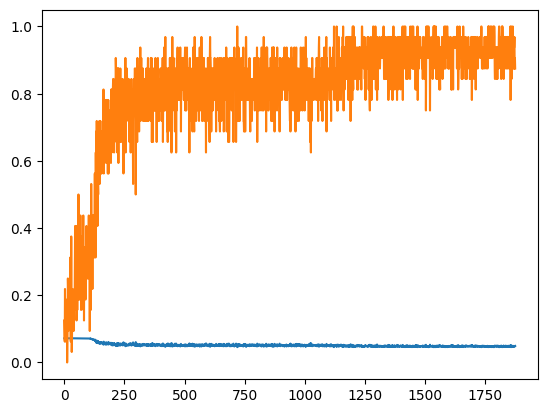

In [35]:
plt.plot(losses)
plt.plot(accs)